# IAM hands-on session from the 2019 AERE pre-conference Workshop

## 6. Build your own model

In this section we will build our own model instead of just loading one from an existing package. Our model will be _very_ simple: we will just create a damage function. At the end, we will add this new damage function component into the FUND model, thus structurally modifying FUND.

### Configuration

In [1]:
use_explore = false;

### Defining a component and running it standalone

First step, as always, is to load the [Mimi.jl](https://github.com/mimiframework/Mimi.jl) package.

In [2]:
using Mimi

The next step is to create a new Mimi component. To do so, we use the `@defcomp` macro. The first argument there is the name of the new component we are creating, in our case `mydamage`. That is followed with a block that defines what indices we want to use in this component (only `regions` in our case), what parameters and variables our component has, and finally with a `run_timestep` function that runs once for each timestep when the component is run. The actual equations for our component will go into that function.

In [3]:
@defcomp mydamage begin
    regions = Index()
    
    myloss = Variable(index=[time, regions])
    
    temp = Parameter(index=[time])
    income = Parameter(index=[time, regions])
    α = Parameter()
    
    function run_timestep(p, v, d, t)
        for r in d.regions
            v.myloss[t,r] = p.α * p.temp[t] * p.income[t,r]
        end
    end
end

We now have a fully self-contained component definition. In order to run it, we need to create a new `Model` and then add our component to this new model. To create a new, empty model, we call `Model()`:

In [4]:
m = Model()

0-component Mimi.Model:


Our model will use two dimensions, the `time` dimension (present in all Mimi models), and the `regions` dimension. We next need to set the values that these dimensions can take on. For `time`, we use a range that includes all years between 2000 and 2100, for regions we just use a fixed list of two regions.

In [5]:
set_dimension!(m, :time, 2000:2100)
set_dimension!(m, :regions, [:US, :China])

We can now add our component to the new, still empty, model we created by using the `add_comp!` function:

In [6]:
add_comp!(m, mydamage)

Mimi.ComponentReference(1-component Mimi.Model:
  mydamage::Main.mydamage
, :mydamage)

Before we can run our model, we need to set values for all the parameters of our model, or rather the parameters in the component we added. We can do this with the familiar `set_param!` function:

In [7]:
set_param!(m, :mydamage, :temp, range(0., stop=2., length=101))
set_param!(m, :mydamage, :income, fill(10., 101, 2))
set_param!(m, :mydamage, :α, 0.03)

At this point our model is ready to be run:

In [8]:
run(m)

If we are running locally, we can use the `explore` function to look at the values of variables and parameters in our model:

In [9]:
if use_explore
    explore(m)
end

We can also use the `Mimi.plot` function to explore the data in our model:

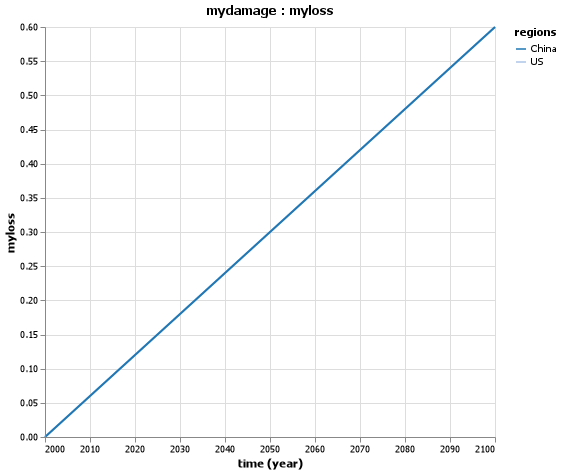

In [10]:
Mimi.plot(m, :mydamage, :myloss)

### Integrate into FUND

We can also integrate out new component into an existing model. In our example we will add it to the FUND model.

The first step is to load the FUND package:

In [11]:
using MimiFUND

We then obtain a model instance:

In [12]:
m_fund = MimiFUND.get_model()

29-component Mimi.Model:
  scenariouncertainty::MimiFUND.scenariouncertainty
  population::MimiFUND.population
  geography::MimiFUND.geography
  socioeconomic::MimiFUND.socioeconomic
  emissions::MimiFUND.emissions
  climateco2cycle::MimiFUND.climateco2cycle
  climatech4cycle::MimiFUND.climatech4cycle
  climaten2ocycle::MimiFUND.climaten2ocycle
  climatesf6cycle::MimiFUND.climatesf6cycle
  climateforcing::MimiFUND.climateforcing
  climatedynamics::MimiFUND.climatedynamics
  biodiversity::MimiFUND.biodiversity
  climateregional::MimiFUND.climateregional
  ocean::MimiFUND.ocean
  impactagriculture::MimiFUND.impactagriculture
  impactbiodiversity::MimiFUND.impactbiodiversity
  impactcardiovascularrespiratory::MimiFUND.impactcardiovascularrespiratory
  impactcooling::MimiFUND.impactcooling
  impactdiarrhoea::MimiFUND.impactdiarrhoea
  impactextratropicalstorms::MimiFUND.impactextratropicalstorms
  impactforests::MimiFUND.impactforests
  impactheating::MimiFUND.impactheating
  impactvectorb

At this point we can simply add our new component to the model instance we just created by calling `add_comp!`. There is one twist here: we want to make sure that the `run_timestep` function for our new component runs before the `impactaggregation` component runs. We can enforce this by passing the `before` keyword argument.

In [13]:
add_comp!(m_fund, mydamage, before=:impactaggregation)

Mimi.ComponentReference(30-component Mimi.Model:
  scenariouncertainty::MimiFUND.scenariouncertainty
  population::MimiFUND.population
  geography::MimiFUND.geography
  socioeconomic::MimiFUND.socioeconomic
  emissions::MimiFUND.emissions
  climateco2cycle::MimiFUND.climateco2cycle
  climatech4cycle::MimiFUND.climatech4cycle
  climaten2ocycle::MimiFUND.climaten2ocycle
  climatesf6cycle::MimiFUND.climatesf6cycle
  climateforcing::MimiFUND.climateforcing
  climatedynamics::MimiFUND.climatedynamics
  biodiversity::MimiFUND.biodiversity
  climateregional::MimiFUND.climateregional
  ocean::MimiFUND.ocean
  impactagriculture::MimiFUND.impactagriculture
  impactbiodiversity::MimiFUND.impactbiodiversity
  impactcardiovascularrespiratory::MimiFUND.impactcardiovascularrespiratory
  impactcooling::MimiFUND.impactcooling
  impactdiarrhoea::MimiFUND.impactdiarrhoea
  impactextratropicalstorms::MimiFUND.impactextratropicalstorms
  impactforests::MimiFUND.impactforests
  impactheating::MimiFUND.impac

Once again we need to set some parameter values for our component:

In [14]:
set_param!(m_fund, :mydamage, :α, 0.01)

For the component parameters `temp` and `income` we don't want to set exogenous values, though. Instead, we want to pick up the values that are computed in other components in the FUND model. To do so, we call the `connect_param!` function:

In [15]:
connect_param!(m_fund, :mydamage, :temp, :climatedynamics, :temp)
connect_param!(m_fund, :mydamage, :income, :socioeconomic, :income)

Next we run the model:

In [16]:
run(m_fund)

At this point we can start to explore the output from our new damage function inside the FUND model:

In [17]:
if use_explore
    explore(m_fund)
end

Or we can directly access the `myloss` variable:

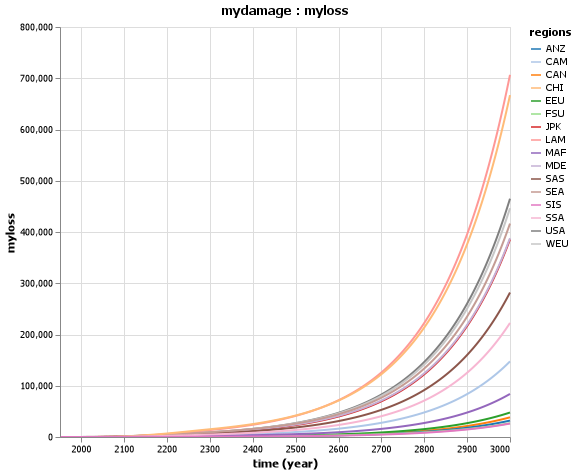

In [18]:
Mimi.plot(m_fund, :mydamage, :myloss)